In [1]:
import os
import glob
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
def load_average_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [3]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc], ["rsivl", "visc"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_subject_scores():
    visc = "./participant_files/"

    files = glob.glob(visc + "*.csv")

    labels = []
    for f in files:
        df = pd.read_csv(f)
        base = os.path.basename(f)
        df = df.rename(columns={"score": "participant{}".format(os.path.splitext(base)[0])})        
        labels.append(df)

    df = pd.concat([df.set_index('image') for df in labels], axis=1, join='outer')

    return labels, df

In [5]:
def load_subject_scores():
    rsivl = "/ptmp/tshen/shared/subject_level_data/rsivl_labels.csv"
    visc = "/ptmp/tshen/shared/subject_level_data/visc_labels.csv"
    visc_participant_ratings = "/ptmp/tshen/shared/subject_level_data/visc_participant_files/"

    labels = {}
    labels['rsivl'] = pd.read_csv(rsivl)
    labels['visc'] = pd.read_csv(visc)

    files = glob.glob(visc_participant_ratings + "*.csv")

    participant_ratings_list = []
    for f in files:
        df = pd.read_csv(f)
        base = os.path.basename(f)
        df = df.rename(columns={"image":"filename", "score": "participant{}".format(os.path.splitext(base)[0])})        
        participant_ratings_list.append(df)

    participant_df = pd.concat([df.set_index('filename') for df in participant_ratings_list], axis=1, join='outer')
    labels['visc'] = pd.concat([labels['visc'].set_index('filename'), participant_df], axis=1, join='outer')
    labels['visc']['filename'] = labels['visc'].index

    return labels

In [6]:
def join_preds_labels(preds, avg_labels, subject_labels):
    data = {}
    
    for k in ["rsivl", "visc"]:
        data[k] = pd.concat(
            [df.set_index("filename") for df in [preds[k], avg_labels[k][['filename', 'complexity']], subject_labels[k]]], 
            axis=1, join='inner').reset_index()

        if k == 'rsivl':
            data[k]['computed_average'] = data[k][['participant{}'.format(i) for i in range(1, 27)]].mean(axis=1)

        elif k == 'visc':
            data[k]['computed_average'] = data[k][['rating{}'.format(i) for i in range(1, 11)]].mean(axis=1)

        if k != 'ic9600':
            assert len(data[k]) == len(preds[k]) == len(avg_labels[k]) == len(subject_labels[k])
        else:
            pass

    assert data['rsivl'].isnull().values.any() == False
    for i in range(1, 41):
        assert data['visc']['participant{}'.format(i)].isna().sum() == (800-200)

    return data

In [7]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [8]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
avg_labels = load_average_scores()
subject_labels = load_subject_scores()
data = join_preds_labels(preds, avg_labels, subject_labels)

# Remove invalid rows

In [12]:
data['rsivl'] = data['rsivl'][data['rsivl'].participant1 != -9999]

In [13]:
assert len(data['rsivl']) == 48
assert (data['rsivl'] == -9999).sum(axis=0).sum() == 0

# Rank Variable Transformation

In [14]:
def rank_transform(data, levels):
    for l in levels:
        data['rsivl']['{}_rank'.format(l)] = data['rsivl'][l].rank(axis=0, method="average")

    for i in range(1, 26+1):
        data['rsivl']['rank{}'.format(i)] = data['rsivl']['participant{}'.format(i)].rank(axis=0, method="average")

In [15]:
rank_transform(data, levels)

/tmp/ipykernel_58922/1395816080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsivl']['{}_rank'.format(l)] = data['rsivl'][l].rank(axis=0, method="average")
/tmp/ipykernel_58922/1395816080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsivl']['{}_rank'.format(l)] = data['rsivl'][l].rank(axis=0, method="average")
/tmp/ipykernel_58922/1395816080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

# One-vs-rest with outlier participants removed

## RSIVL

In [22]:
def get_correlations(x, y):
    model = np.poly1d(np.polyfit(x, y, 1))                
    return stats.pearsonr(x, y), stats.spearmanr(x, y), r2_score(y, model(x))

def get_specified_cols(n_cols, choice):
    first_idxs = np.zeros(n_cols, dtype=bool)
    first_idxs[choice] = True
    second_idxs = ~first_idxs
    return first_idxs, second_idxs

def sample_random_cols(n_cols, n_first_split):
    choice = np.random.choice(range(n_cols), size=(n_first_split,), replace=False)
    return get_specified_cols(n_cols, choice)

def split_vs_split(x, first_split_size=0.5, first_split_idxs=None, n_repeats=1):
    n_ratings = x.shape[1]
    n_images = x.shape[0]

    results = []

    for _ in range(n_repeats):

        if first_split_idxs is not None:  # choosing the split columns instead of randomizing them
            first_idxs, second_idxs = get_specified_cols(n_ratings, first_split_idxs)
        else:
            first_idxs, second_idxs = sample_random_cols(n_ratings, int(first_split_size*n_ratings))
        
        first_split = x[:, first_idxs]
        second_split = x[:, second_idxs]

        first_means = np.nanmean(first_split, axis=1) if len(first_split.shape) == 2 else first_split
        second_means = np.nanmean(second_split, axis=1) if len(second_split.shape) == 2 else second_split

        # print(first_split.shape, second_split.shape, first_means.shape, second_means.shape)

        results.append(get_correlations(first_means, second_means))

    return results

In [23]:
def one_vs_rest(x, n_participants):
    results = []
    for i in range(n_participants):
        if np.isnan(x[:, i]).sum() > 0:
            a = x[~np.isnan(x[:, i])]            
        else:
            a = x

        results.append(split_vs_split(a, first_split_idxs=[i], n_repeats=1)[0])

    return results

In [51]:
def plot_scatterplots(results, n_participants, title):
    columns = ["complexity"] + levels
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
    plt.suptitle(title, fontsize=14)

    for i, c in enumerate(["Pearson", "Spearman", "R^2"]):
        correlations = [x[i].statistic for x in results] if c != "R^2" else [x[i] for x in results]
        axes[i].scatter(list(range(1, n_participants+1)), correlations)
        axes[i].set_xlabel("Participant number")
        axes[i].set_ylabel(c)

def plot_corr_boxplots(results, title):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title, fontsize=14)

    for i, c in enumerate(["Pearson", "Spearman", "R^2"]):
        correlations = [x[i].statistic for x in results] if c != "R^2" else [x[i] for x in results]
        axes[i].boxplot(correlations)
        axes[i].set_xlabel(c)
        axes[i].get_xaxis().set_ticks([])

def plot_hists(results, points, title):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title, fontsize=14)

    for i, c in enumerate(["Pearson", "Spearman", "R^2"]):
        correlations = [x[i].statistic for x in results] if c != "R^2" else [x[i] for x in results]
        axes[i].hist(correlations)
        axes[i].set_xlabel(c)
        offset = 0.03*(axes[i].get_ylim()[1] - axes[i].get_ylim()[0])
        axes[i].scatter(points[c], offset, s=20, color="red", label="Our model")
        axes[i].legend()

In [19]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

In [28]:
def rank_xform(c):
    return c.rank(axis=0, method="average")

In [32]:
x = rank_xform(data['rsivl']["64points"])
y = data['rsivl'][["participant{}".format(i) for i in participants]].mean(axis=1)
result = get_correlations(x, y)
pearson, spearman, r2 = result[0].statistic, result[1].statistic, result[2]

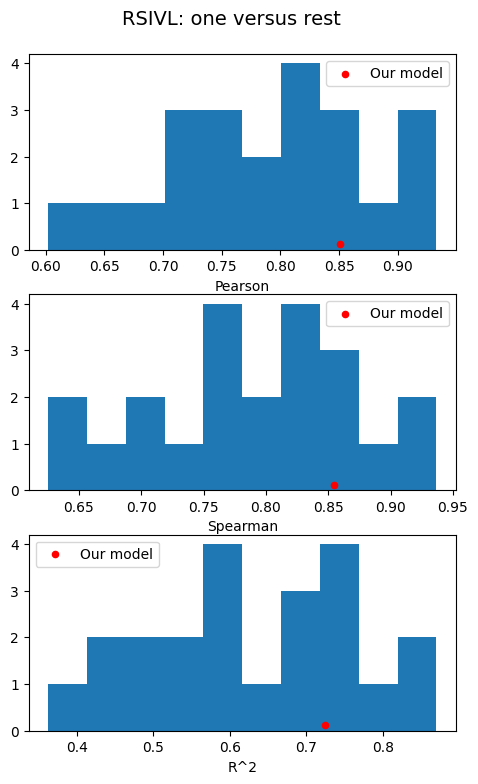

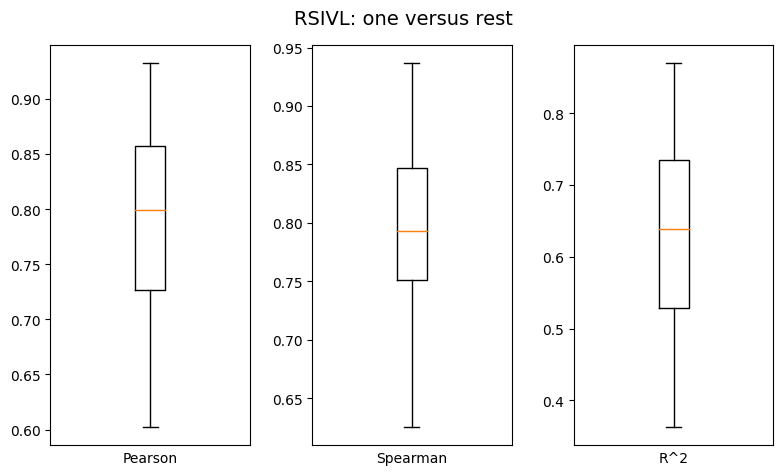

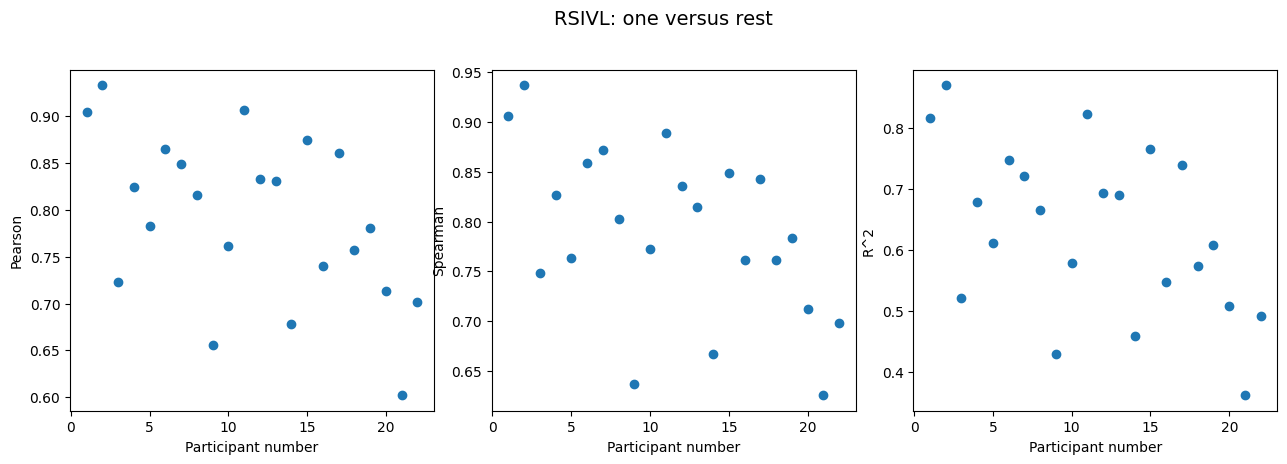

In [52]:
participant_matrix = data['rsivl'][['participant{}'.format(i) for i in participants]].to_numpy(dtype=np.float64)
results = one_vs_rest(participant_matrix, 22)
plot_hists(results, {"Pearson": pearson, "Spearman": spearman, "R^2": r2}, "RSIVL: one versus rest")
plot_corr_boxplots(results, "RSIVL: one versus rest")
plot_scatterplots(results, 22, "RSIVL: one versus rest")

## VISC

In [274]:
participants = list(range(1, 41))
participants = [x for x in participants if x not in [7, 14, 28]]

In [275]:
x = rank_xform(data['visc']["64points"])
y = data['visc'][["participant{}".format(i) for i in participants]].mean(axis=1)
result = get_correlations(x, y)
pearson, spearman, r2 = result[0].statistic, result[1].statistic, result[2]

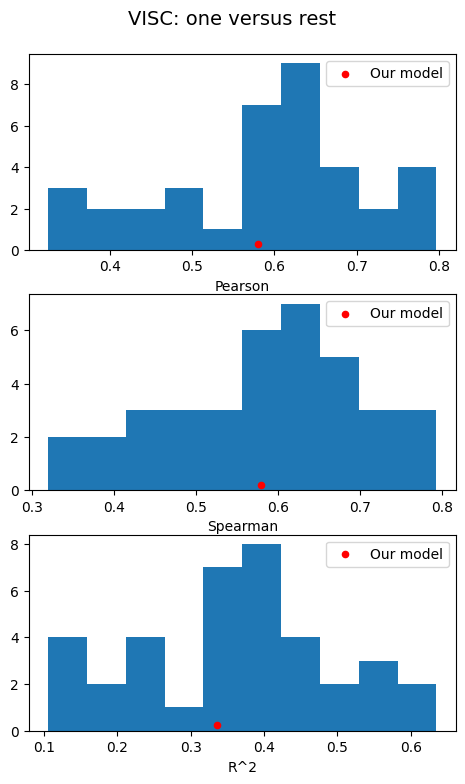

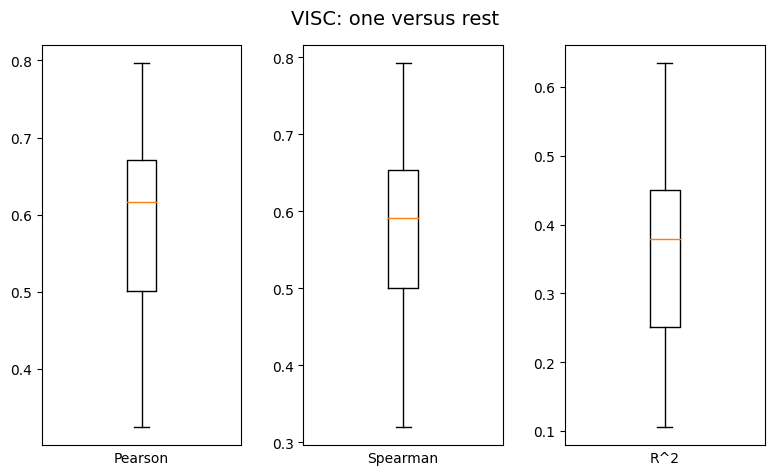

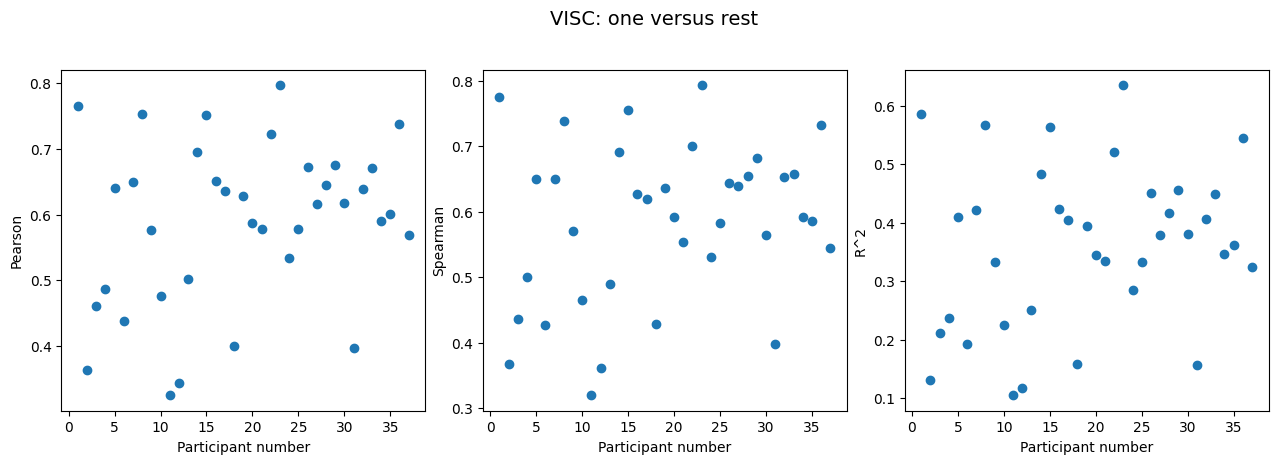

In [276]:
participant_matrix = data['visc'][['participant{}'.format(i) for i in participants]].to_numpy(dtype=np.float64)
results = one_vs_rest(participant_matrix, 37)
plot_hists(results, {"Pearson": pearson, "Spearman": spearman, "R^2": r2}, "VISC: one versus rest")
plot_corr_boxplots(results, "VISC: one versus rest")
plot_scatterplots(results, 37, "VISC: one versus rest")

# Logloss

## Discrete Density (Histogram)

Implements the cross-entropy (for each image) $\sum _x -p(x)\log q(x)$ where $p(x) = \delta(x-\hat x)$ is the model prediction and $q(x)$ is the empirical, participant distribution. Hence this reduces to the logloss, $\sum_{\text{images},  i} -\log q_i(\hat x)$ 

In [356]:
def sqrt_xform(c):
    return np.sqrt(c)

def bounded_logloss(nx, N, eps, num_bins):
    p = (nx + eps)/(N + num_bins*eps)
    return -np.log(p)

def get_pseudo_params(num_participants, num_bins):
    # C: maximum/clip value of the Cost = -log q(x), which sets the minimum probability q(x) = e^(-C) for a bin
    # the logic is as follows: we're going to distribute 0.1*num_participants pseudo-ratings evenly amongst num_bins
    # the probability for a bin with no real ratings is (0.1*num_participants/num_bins) / num_participants = 0.1/num_bins
    q_min = 0.1/num_bins
    C = -np.log(q_min)
    eps = num_participants/(1/q_min - num_bins)
    if type(eps) == float:
        print(q_min, C, eps)
    else:
        print(q_min, C, min(eps))
    return q_min, C, eps

def model_predict(regressor, label):
    model = np.poly1d(np.polyfit(regressor, label, 1))
    x_hat = np.polyval(model, regressor)

    return x_hat

def discrete_logloss(regressor, label, ratings_matrix, num_participants, bin_step=10):  
    # num_participants is either a scalar or array of #ratings in each row

    x_hat = model_predict(regressor, label)

    # for discrete bins, the domain is 0-100
    x_hat = np.clip(x_hat, 0, 100)

    bins = np.arange(0, 100+1, bin_step)
    num_bins = len(bins)-1

    def histogram_partial(a):
        return np.histogram(a, bins=bins)[0]

    nx = np.apply_along_axis(histogram_partial, 1, ratings_matrix)

    def nonzero_idx_partial(a):
        return np.nonzero(a)[0][0]

    p_x = np.apply_along_axis(histogram_partial, 1, np.expand_dims(x_hat, 1))
    p_x_idx = np.apply_along_axis(nonzero_idx_partial, 1, p_x)

    n_x_hat = nx[np.arange(len(p_x_idx)), p_x_idx]
    q_min, C, eps = get_pseudo_params(num_participants, num_bins)
    logloss = np.mean(bounded_logloss(n_x_hat, num_participants, eps, num_bins))

    return logloss, np.exp(-logloss)

### RSIVL

In [349]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

regressor = sqrt_xform(data['rsivl']["64points"])
label = data['rsivl'][["participant{}".format(i) for i in participants]].mean(axis=1)
ratings_matrix = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy()
num_participants = ratings_matrix.shape[1]

0.02 3.912023005428146 0.4888888888888889
(1.1777709744952707, 0.3079644346796481)
0.01 4.605170185988091 0.24444444444444444
(1.892049710500725, 0.1507624724967088)


In [ ]:
print(discrete_logloss(regressor, label, ratings_matrix, num_participants, bin_step=20))
print(discrete_logloss(regressor, label, ratings_matrix, num_participants, bin_step=10))

### VISC

In [352]:
participants = list(range(1, 41))
participants = [x for x in participants if x not in [7, 14, 28]]

In [353]:
regressor = sqrt_xform(data['visc']["64points"])
label = data['visc'][["participant{}".format(i) for i in participants]].mean(axis=1)
ratings_matrix = data['visc'][["participant{}".format(i) for i in participants]].to_numpy()  # WARNING: relies on np.histogram ignoring nans
num_participants = (~np.isnan(ratings_matrix)).sum(1)

In [354]:
print(discrete_logloss(regressor, label, ratings_matrix, num_participants, bin_step=20))
print(discrete_logloss(regressor, label, ratings_matrix, num_participants, bin_step=10))

0.02 3.912023005428146 0.2
(1.4456903196645012, 0.23558339256182856)
0.01 4.605170185988091 0.1
(2.291102083344868, 0.10115491924879405)


## Continuous Density (kernel)

Same thing but $q_i(\hat x)$ is now a pdf instead of a pmf in the logloss, $\sum_{\text{images},  i} -\log q_i(\hat x)$ 

### RSIVL

In [396]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

regressor = sqrt_xform(data['rsivl']["64points"])
label = data['rsivl'][["participant{}".format(i) for i in participants]].mean(axis=1)
ratings_matrix = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy()
num_participants = ratings_matrix.shape[1]

In [414]:
def continuous_logloss(regressor, label, ratings_matrix, bandwidth=10):
    x_hat = model_predict(regressor, label)

    num_images = ratings_matrix.shape[0]

    logloss = []
    for i in range(num_images):

        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.expand_dims(ratings_matrix[i], 1))
        logloss.append(-kde.score_samples(x_hat[i].reshape(-1, 1)))

    logloss = np.concatenate(logloss, axis=0).mean()

    return logloss, np.exp(-logloss)

In [424]:
print(continuous_logloss(regressor, label, ratings_matrix, bandwidth=2))
print(continuous_logloss(regressor, label, ratings_matrix, bandwidth=5))
print(continuous_logloss(regressor, label, ratings_matrix, bandwidth=10))
print(continuous_logloss(regressor, label, ratings_matrix, bandwidth=20))
print(continuous_logloss(regressor, label, ratings_matrix, bandwidth=50))

(4.5173518455063055, 0.010917897700088658)
(4.104097323414238, 0.01650491071252808)
(4.082443141282464, 0.01686620874413722)
(4.263497840268088, 0.014072991143858515)
(4.90077635677818, 0.0074408041092412485)


array([0.00998846])

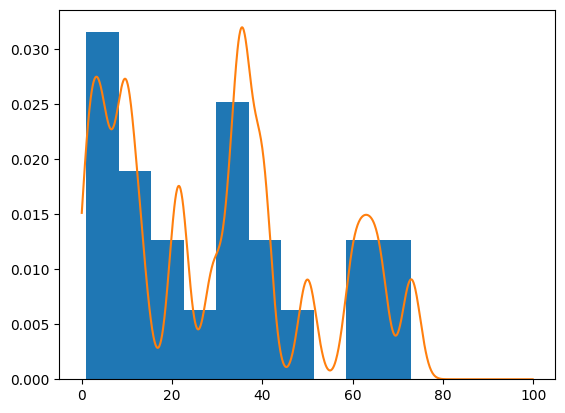

In [422]:
plt.hist(ratings_matrix[0], density=True, bins=10)
x = np.arange(0, 100, 0.1)
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(np.expand_dims(ratings_matrix[0], 1))
plt.plot(x, np.exp(kde.score_samples(x.reshape(-1, 1))))
np.exp(kde.score_samples(x_hat[0].reshape(-1, 1)))
# kde.score_samples(x_hat[0].reshape(-1, 1))